In [1]:
from pickle import FALSE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

# Time Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# Metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

# Grid Search
from sklearn.model_selection import GridSearchCV

# Data processing
import pandas as pd
import numpy as np

# Normalize
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/cvxpy_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Data importation
data = pd.read_sas("datas/total_red.sas7bdat")
# Useful to plot the model 
index = data.set_index('TRIMESTRE').index.unique()

In [42]:
from processing_datas import *
from linear_models import *

# Processing Functions

## Clean_data

In [9]:
def clean_data(data:pd.DataFrame,start:int,period:int,chronique,col_used:None,split=0.2,norm="MinMax"):
  """
  - Returns the data normalized and prepared for t -> X_train,X_test,y_train,y_test,X_validation in the case of a non null split else just return the all DataFrame
  - X_train and X_test are DataFrame and y_train,y_test are Series
  - Chronique can take these values (it's an object):
    * b'CHR2'
    * b'CHR8'
    * b'Total'
  - You have to enter the initial
  - Norm can take these values:
    * MinMax for MinMaxScaler
    * StdSca
    * Not if you don't want to normalize your data
  - Period
  Choose the type of data you want to use (12, 24, or 36 months)
  """
  # Data processing
  X = data[data.CHRONIQUE == chronique]
  X = X.iloc[start:,]
  X = X.set_index(X.TRIMESTRE)
  X["DR"] = X["DR"].shift(-period//3)
  Y = X.DR.iloc[:-period//3]
  X = X.drop(columns=["DR","TRIMESTRE","CHRONIQUE"])
  if col_used != None:
    X = X[col_used]
  else:
      X = X.drop(columns=['CD_TY_CLI_RCI_2','CD_ETA_CIV_2','CD_MOD_HABI_2','CD_PROF_3','CD_QUAL_VEH_2'])
  X_validation = X.iloc[-period//3:,:]
  X = X.iloc[:-period//3,:]

  # Train Split
  if split == 0:
    X_train, X_test, y_train, y_test = X.dropna(axis=1),X.dropna(axis=1),Y,Y
  
  else:
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=split,shuffle=False)
  index_train = X_train.index
  index_test = X_test.index
  index_validation = X_validation.index

  # Normalization
  if norm == "Not":
    if split == 0:
      return X_train,y_train
    else:
      return X_train, X_test, y_train, y_test,X_validation
  
  elif norm == 'MinMax':
    scaler_train = MinMaxScaler()
    scaler_test = MinMaxScaler()
    scaler_validation = MinMaxScaler()
    X_train = pd.DataFrame(scaler_train.fit_transform(X_train),index=index_train,columns=X_train.columns)
    X_test = pd.DataFrame(scaler_test.fit_transform(X_test),index=index_test,columns=X_test.columns)
    X_validation = pd.DataFrame(scaler_validation.fit_transform(X_validation),index=index_validation,columns=X_validation.columns)

  elif norm == 'StdSca':
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()
    scaler_validation = StandardScaler()
    X_train = pd.DataFrame(scaler_train.fit_transform(X_train),index=index_train,columns=X_train.columns)
    X_test = pd.DataFrame(scaler_test.fit_transform(X_test),index=index_test,columns=X_test.columns)
    X_validation = pd.DataFrame(scaler_validation.fit_transform(X_validation),index=index_validation,columns=X_validation.columns)
  
  else:
    print("This norm doesn't exist")

  if split == 0:
    return X_train,y_train
  
  else:
    return X_train, X_test, y_train, y_test,X_validation

In [ ]:
X_train, X_test, y_train, y_test = clean_data(data,start=2,chronique=b'CHR2',col_used=['median_5', 'mean_8'],split=0.2,norm="MinMax")

In [ ]:
print(type(X_train),type(X_test),type(y_train),type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


# Regression Functions

## Summary_ml

In [6]:
def summary_ml(X_train,y_train,X_test,y_test,models=["lin","rid","xgb","svr","knn","cat",'tre'],parameters={},metrics=["rmse","mse","mae","r2"]):

    """
    - Returns a DataFrame with all the model you want to train, and his score
    - Models is a list with names of models you want to train. Values in models can be:
      * lin for LinearRegression
      * rid for Ridge
      * las for Lasso
      * ela for ElasticNet
      * xgb for XGBRegressor
      * svr for LinearSVR
      * knn for KNeighborsRegressor
      * cat for CatBoostRegression
      * tre for DecisionTreeRegressor
    - Parameters is a dictionnary containing several dictionnaries for models you want to use. Values of each dictionnary containing parameters can be:
      * p_lin for LinearRegression
      * p_rid for Ridge
      * p_las for Lasso
      * p_ela for ElasticNet
      * p_xgb for XGBRegressor
      * p_svr for LinearSVR
      * p_knn for KNeighborsRegressor
      * p_cat for CatBoostRegression
      * p_tre for DecisionTreeRegressor
    - Metrics is a list to choose the right metric to use. metric is equal to ["mse"] by default. Currently two metrics are taken into account:
      * mse for mean_squared_error
      * mae for mean_absolute_error
      * rmse for root_mean_squarred_error
      * r2 for r2_score

    !BE CAREFUL! Lasso and ElasticNet returns systematically a constant prediction so we do not include them in the predictions
    """
  
 	# Index used to create the DataFrame
    Index = []
    Columns = {metric: [] for metric in metrics}

    for model in models:
        unknown = 0
    # Training the model

        if model == "lin":
            Index.append("LinearRegression")
            if "p_lin" in parameters:
                M = LinearRegression(**parameters["p_lin"])
                M = M.fit(X_train,y_train)
            else:
                M = LinearRegression()
                M = M.fit(X_train,y_train)

        elif model == "rid":
            Index.append("Ridge")
            if "p_rid" in parameters:
                M = Ridge(**parameters["p_rid"])
                M = M.fit(X_train,y_train)
            else:
                M = Ridge()
                M = M.fit(X_train,y_train)

        elif model == "las":
            Index.append("Lasso")
            if "p_las" in parameters:
                M = Lasso(**parameters["p_las"])
                M = M.fit(X_train,y_train)
            else:
                M = Lasso()
                M = M.fit(X_train,y_train)

        elif model == "ela":
            Index.append("ElasticNet")
            if "p_ela" in parameters:
                M = ElasticNet(**parameters["p_ela"])
                M = M.fit(X_train,y_train)
            else:
                M = ElasticNet()
                M = M.fit(X_train,y_train)

        elif model == "xgb":
            Index.append("XGBRegressor")
            if "p_xgb" in parameters:
                M = XGBRegressor(**parameters["p_xgb"])
                M = M.fit(X_train,y_train)                
            else:
                M = XGBRegressor()
                M = M.fit(X_train,y_train)

        elif model == "svr":
            Index.append("LinearSVR")
            if "p_svr" in parameters:
                M = LinearSVR(**parameters["p_svr"])
                M = M.fit(X_train,y_train)                
            else:
                M = LinearSVR()
                M = M.fit(X_train,y_train) 

        elif model == "knn":
            Index.append("KNeighborsRegressor")
            if "p_knn" in parameters:
                M = KNeighborsRegressor(**parameters["p_knn"])
                M = M.fit(X_train,y_train)          
            else:
                M = KNeighborsRegressor()
                M = M.fit(X_train,y_train)

        elif model == "cat":
            Index.append("CatBoostRegressor")
            if "p_cat" in parameters:
                M = CatBoostRegressor(**parameters["p_cat"])
                M = M.fit(X_train,y_train)                
            else:
                M = CatBoostRegressor(verbose=0)
                M = M.fit(X_train,y_train)
                

        elif model == "tre":
            Index.append("DecisionTreeRegressor")
            if "p_tre" in parameters:
                M = DecisionTreeRegressor(**parameters["p_tre"],random_state=False)
                M = M.fit(X_train,y_train)                
            else:
                M = DecisionTreeRegressor(random_state=False)
                M = M.fit(X_train,y_train)

        else:
            print("The model is unknown")
            unknown = 1
            
        if unknown == 0:
          y_pred = M.predict(X_test)
        
        else:
          y_pred != (y_test == False)

        # Calculate the score for each metric
        for metric in metrics:
            if metric == "rmse":
                Columns["rmse"].append(mean_squared_error(y_test,y_pred,squared=False)) 
            
            elif metric == "mse":
                Columns["mse"].append(mean_squared_error(y_test,y_pred))

            elif metric == "mae":
                Columns["mae"].append(mean_absolute_error(y_test,y_pred)) 

            elif metric == "r2":
                Columns["r2"].append(r2_score(y_test,y_pred)) 

            else:
                Columns[metric].append(None)

    # We transform the dictionnary into a DataFrame
    df = pd.DataFrame.from_dict(Columns)
    df["Index"] = Index
    df = df.set_index(df.Index)
    df = df.drop(["Index"],axis = 1)
    # Condition on r2 because we want the biggest r2
    if df.columns[0] == "r2":
      df = df.sort_values(by=df.columns[0],ascending=False)
    else:
      df = df.sort_values(by=df.columns[0],ascending=True)
    
    return df

In [71]:
def plot_pred_detail(y_train,y_test,y_train_pred,y_test_pred,index,name_model,df_score,y_validation=None,ic=True):
  """
  Plot the prediction of the model in order to compare with the real model
  If y_validation is None this do not represent the value predicte without knowing the real value 
  name_model is a string where values can be:
  * LinearRegression for LinearRegression
  * Ridge for Ridge
  * Lasso for Lasso
  * ElasticNet for ElasticNet
  * XGBRegressor for XGBRegressor
  * LinearSVR for LinearSVR
  * KNeighborsRegressor for KNeighborsRegressor
  * CatBoostRegression for CatBoostRegression
  """

  fig, ax = plt.subplots(figsize=(18,8))
  # r2 = df_score.loc[name_model,'r2']
  rmse = df_score.loc[name_model,'rmse']
  y_train = list(y_train)
  date_split = index[len(y_train)]
  if type(y_validation) != type(None):
    y = y_train + list(y_test) + list(np.repeat(np.nan,y_validation.shape[0]))
    y_p = list(y_train_pred) + list(y_test_pred) + list(y_validation)
  else: 
    y = y_train + list(y_test)
    y_p = list(y_train_pred) + list(y_test_pred)
  y_plot = ax.plot(index,y,color='c',label='historical values')
  y_pred_plot = ax.plot(index,y_p,color='r',linestyle='dashed',label='predicted values')
  ax.axvline(x = date_split, color = 'b')
  

  #if ic:
    #hypothesis that the errors are normally distributed; IC de 90%
    #ax.fill_between(index, y_p - 1.96*rmse, y_p + 1.96*rmse, color='r', alpha=0.1,label='IC90%')

  extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
  scores = (r"$RMSE={:.6f}$").format(rmse)
  plt.legend([extra], [scores], loc='upper center')

  plt.xlabel("Date")
  plt.ylabel("DR")
  plt.title(f'Model: {name_model}')
  plt.show()

In [72]:
X_train, X_test,y_train, y_test,X_validation = clean_data(data,start=1,chronique=b"CHR2",period=12,col_used=['PIB', 'p5_1', 'CD_PROF_1', 'p95_5'])
index = pd.concat([X_train,X_test],axis=1).index
y_validation = pd.Series(index=X_validation.index,name="DR",data=np.repeat(0.0025,X_validation.shape[0]))

In [73]:
y_validation

TRIMESTRE
2016-06-30    0.0025
2016-09-30    0.0025
2016-12-31    0.0025
2017-03-31    0.0025
Name: DR, dtype: float64

In [74]:
summary = summary_ml(X_train,y_train,X_test,y_test)
summary

/opt/anaconda3/envs/cvxpy_env/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,rmse,mse,mae,r2
Index,,,,
XGBRegressor,0.000228,5.218327e-08,0.000170,-0.662476
DecisionTreeRegressor,0.000231,5.333333e-08,0.000200,-0.699115
CatBoostRegressor,0.000255,6.501442e-08,0.000228,-1.071256
Ridge,0.000272,7.397786e-08,0.000206,-1.356817
KNeighborsRegressor,0.000322,1.038667e-07,0.000273,-2.309027
LinearRegression,0.000374,1.398241e-07,0.000299,-3.454572
LinearSVR,0.000420,1.766329e-07,0.000340,-4.627242


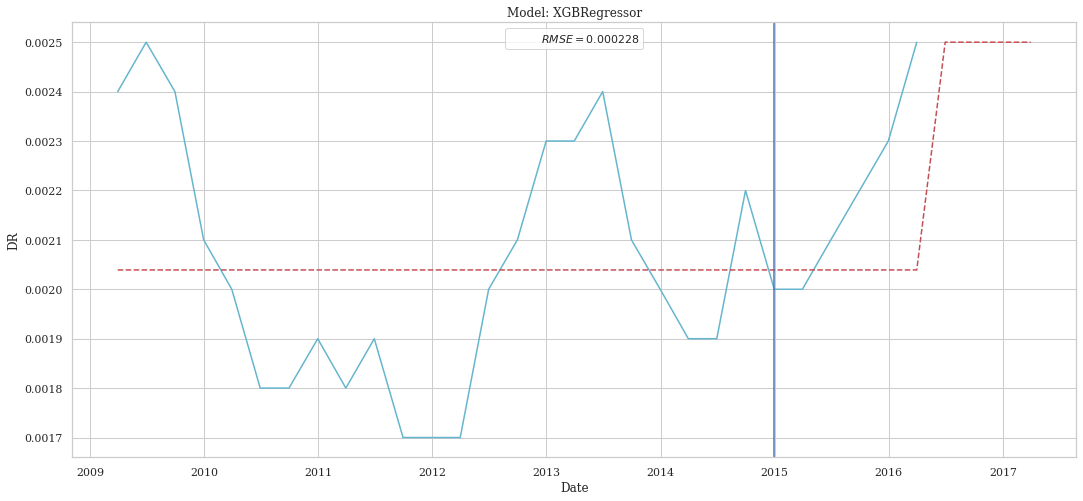

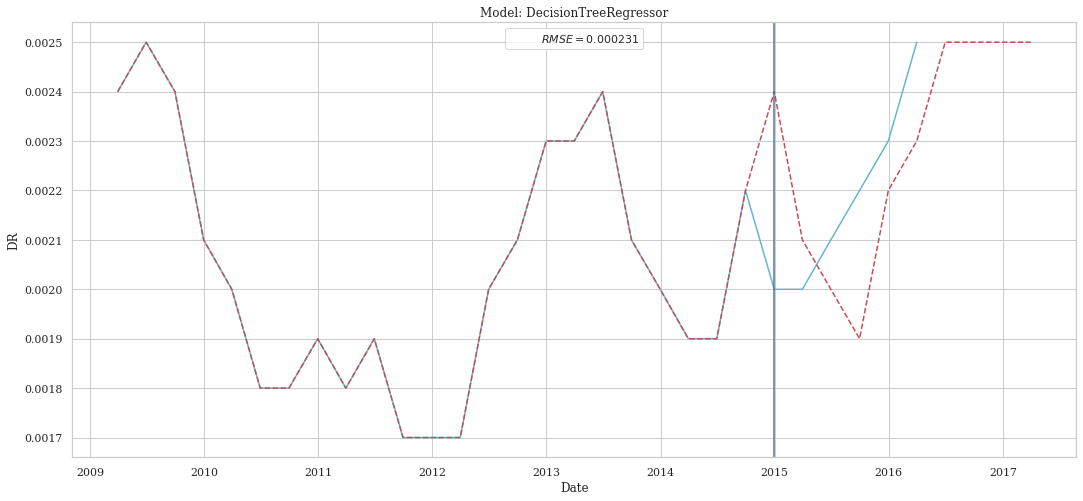

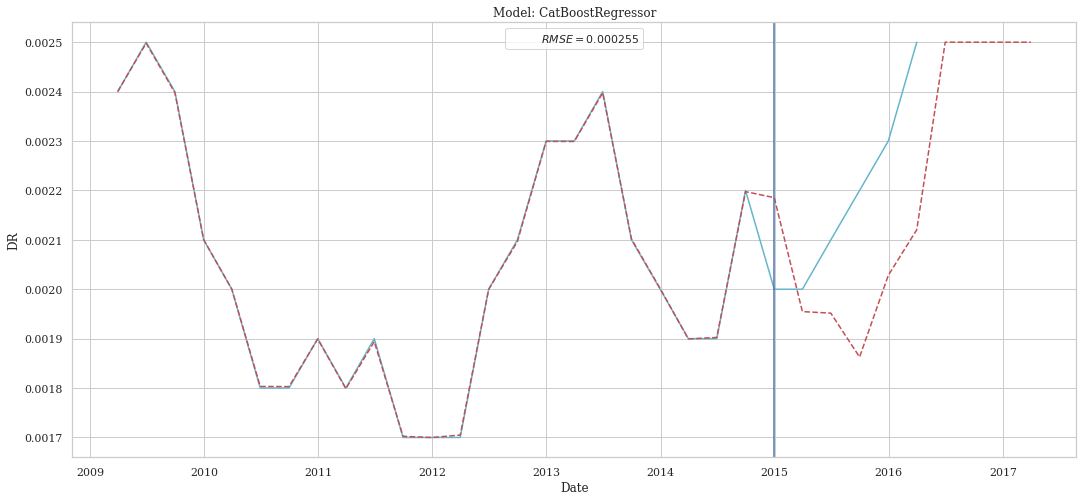

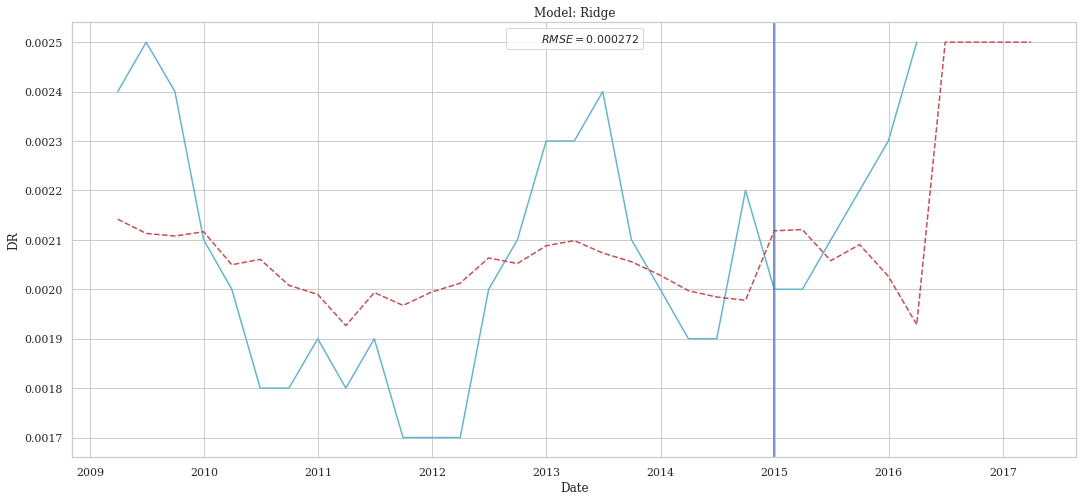

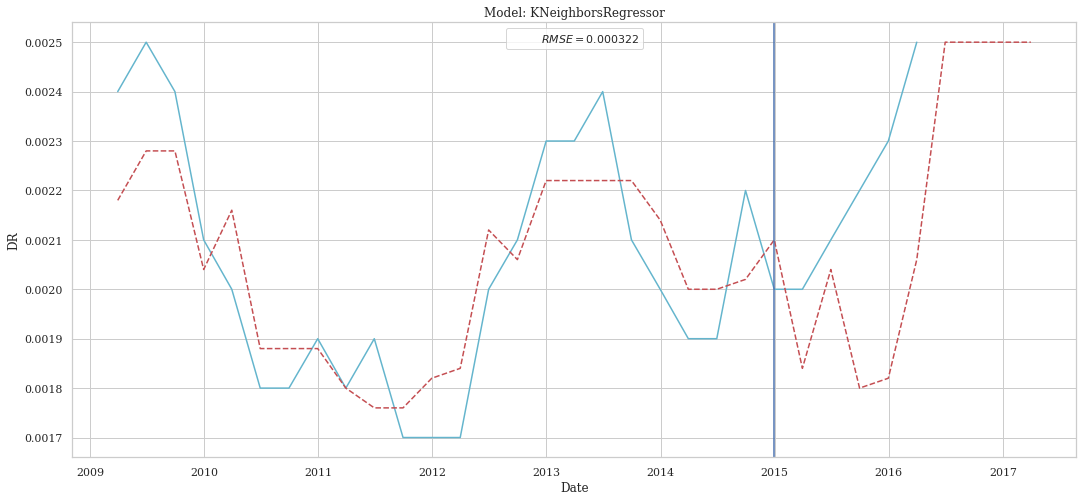

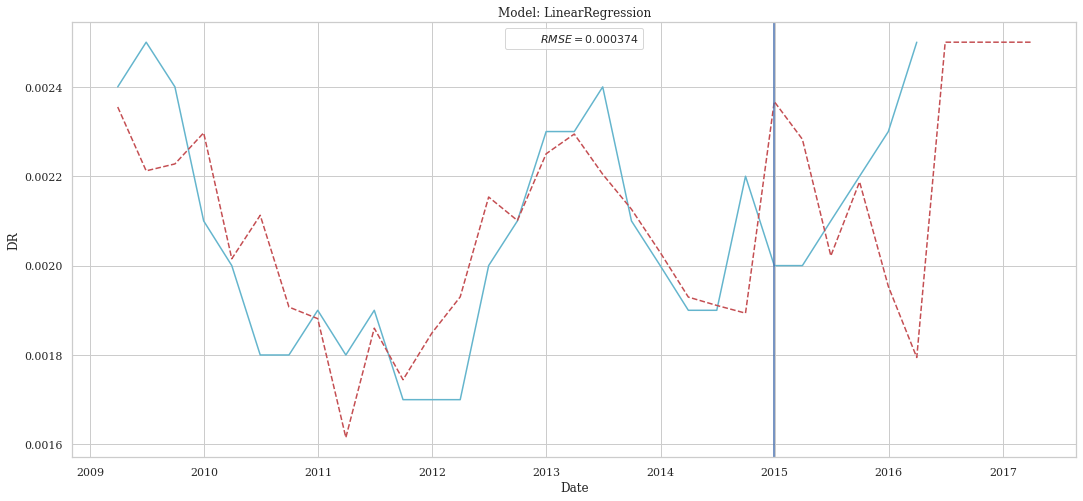

/opt/anaconda3/envs/cvxpy_env/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/envs/cvxpy_env/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


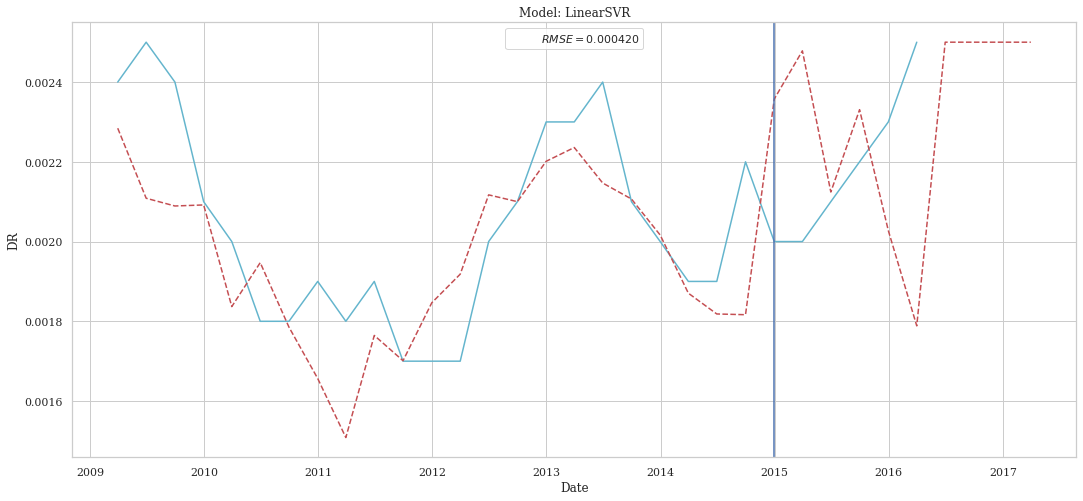

In [81]:
index = data.loc[:,'TRIMESTRE'].unique()[1:]
for i in range(summary.shape[0]): 
  y_train_pred = y_pred(X_train,y_train,X_train,y_train,model=summary.index[i])
  y_test_pred = y_pred(X_train,y_train,X_test,y_test,model=summary.index[i])
  plot_pred_detail(y_train,y_test,y_train_pred,y_test_pred,index,name_model=summary.index[i],df_score=summary,y_validation=y_validation)

# Times Series Functions

## ACF and PCF

In [ ]:
def acf_pacf(y,alpha=0.05,plot=True):
  """
  - Differencing the data while the adfuller test is rejected
  - Plotting the acf and pacf of a series 
  - Alpha is the threshold for the adf test
  - Returns the level of differenciation to use in order to have the stationarity of data
  """

  if type(y) != pd.core.series.Series:
    y = pd.Series(y)
  df = y.to_frame(name="y")
  d=0
  df.index = [i for i in range(y.shape[0])]
  test = adfuller(df.iloc[:,-1])

  while test[1]>=alpha and d<8:
    df = df.copy()
    df[f"y_diff{d+1}"] = df.iloc[:,-1].diff()
    test = adfuller(df.iloc[:,-1].dropna())
    d+=1

  print('\n'+'='*80)
  print(f'Test statistic for the series {df.columns[-1]}: {round(test[0],3)}')
  print(f'P-value for the series {df.columns[-1]}: {round(test[1],5)}')
  print("The data is potentially stationary. We reject the hypothesis of a unit root.")
  print(f"The level of differencing you need to use in order to have stationarity data is {d}.")
  print('='*80+'\n')

  if plot==True:
    if d != 0:
      fig, axes = plt.subplots(df.shape[1],3, sharex=True,figsize=(15,8*df.shape[1]))
      for i in range(df.shape[1]):
        y = df.iloc[:,i].dropna()
        axes[i,0].plot(y)
        axes[i,0].set_title(df.columns[i])
        plot_acf(y.values, ax=axes[i,1],bartlett_confint=True,alpha=0.05)
        axes[i,1].set_title('ACF') 
        plot_pacf(y.values,lags=y.shape[0]//2-1, ax=axes[i,2],alpha=0.05)
        axes[i,2].set_title('PACF') 
    else:
        fig, axes = plt.subplots(df.shape[1],3, sharex=True,figsize=(15,8))
        y = df.iloc[:,0].dropna()
        axes[0].plot(y)
        axes[0].set_title(df.columns[0])
        plot_acf(y.values, ax=axes[1],bartlett_confint=True,alpha=0.05)
        axes[1].set_title('ACF') 
        plot_pacf(y.values,lags=y.shape[0]//2-1, ax=axes[2],alpha=0.05)
        axes[2].set_title('PACF') 
    plt.show()

  return d

In [ ]:
X_train, X_test, y_train, y_test = clean_data(data,start=2,chronique=b'CHR2',col_used=['median_5', 'mean_8'],split=0.2,norm="MinMax")


Test statistic for the series y_diff1: -4.628
P-value for the series y_diff1: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


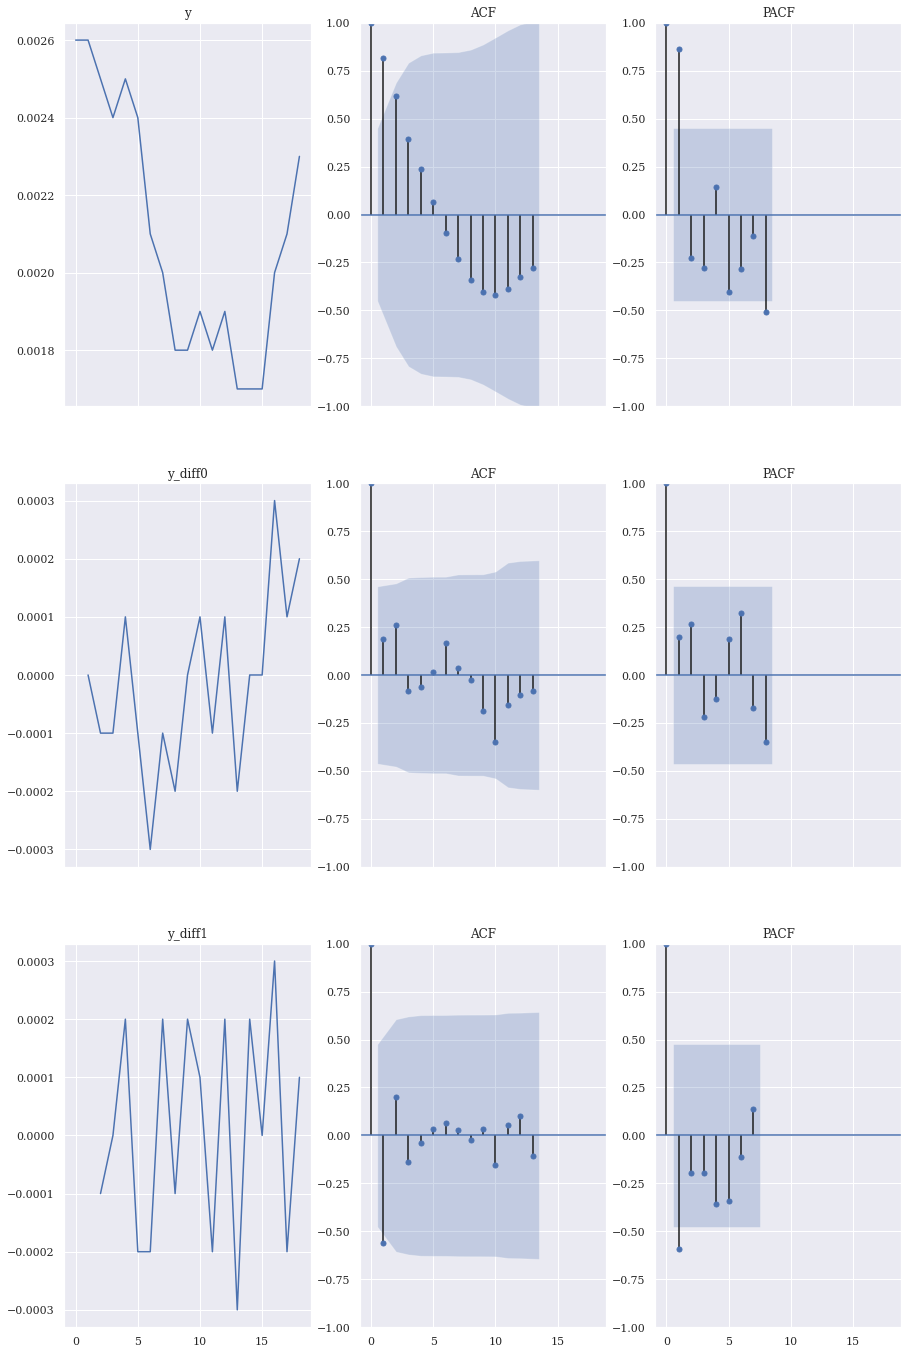

2

In [ ]:
acf_pacf(np.array(y_train),alpha=0.05,plot=True)

## Find_arima_params

In [ ]:
def find_arimax_params(y_train,exog=None,d=None,alpha=0.05,seasonal=False):
  """
  - Returns the best arima parameters for the data
  - You can choose the order of the arima model or let the model choose for you
  - You can choose the order of the seasonal arima model
  - Alpha is the threshold for the adf test
  """

  if d == None:
    d = acf_pacf(np.array(y_train),alpha=alpha,plot=False)

  if type(exog) == type(None):
    model = pm.auto_arima(y_train, d=d,seasonal=seasonal,stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
    print(model.summary())
  
  else:
    model = pm.auto_arima(y_train,exog,d=d,seasonal=seasonal,stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
    print(model.summary())

  # plot the residuals
  residuals = pd.DataFrame(model.resid())
  fig, axes = plt.subplots(1, 2, figsize=(15,5))
  axes[0].plot(residuals)
  axes[0].set_title('Residuals')
  plot_acf(residuals.values, ax=axes[1],bartlett_confint=True,alpha=0.05)
  axes[1].set_title('ACF')
  plt.show()

  # test for stationarity
  test = adfuller(residuals)
  print('\n'+ '='*80)
  print(f'Test statistic for the residuals: {round(test[0],3)}')
  print(f'P-value for the residuals: {round(test[1],5)}')
  if test[1]>=alpha:
    print("The residuals are not stationary. We accept the hypothesis of a unit root.")
  else:
    print("The residuals are potentially stationary. We reject the hypothesis of a unit root.")
    print(f"The level of differencing you need to use in order to have stationarity data is {d}.")
  print('='*80+'\n')

  return model


Test statistic for the series y_diff1: -4.628
P-value for the series y_diff1: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-232.104, Time=0.72 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-240.114, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-244.345, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-245.693, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-242.039, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-243.004, Time=0.44 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-243.766, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-241.347, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-246.835, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-244.510, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-241.95

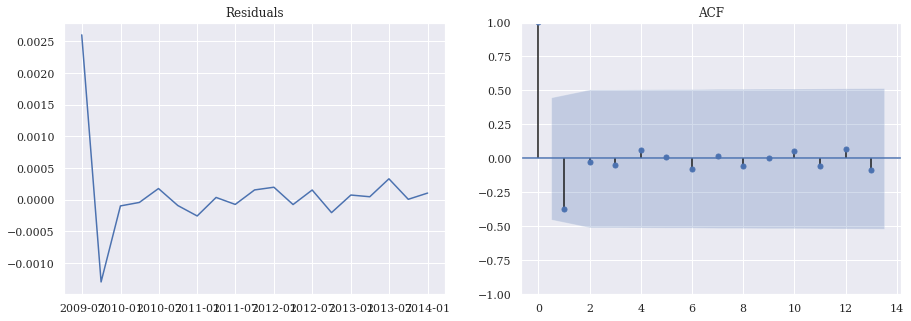


Test statistic for the residuals: -1.301
P-value for the residuals: 0.62859
The residuals are not stationary. We accept the hypothesis of a unit root.



In [ ]:
model = find_arimax_params(y_train,d=None,alpha=0.05,seasonal=False)

## Plot_arimax_fit

In [ ]:
def plot_arimax_fit(model,y_train,y_test,exog_train=None,exog_test=None):
    """
    - Plot the fit and the prediction of the arimax model (with exogenous data or not)
    - A horizontal bar is plotted to show the test set
    """

    y_total = pd.concat([y_train,y_test])

    if type(exog_train)==type(None) and type(exog_test)==type(None):
      y_fit = model.predict(y_train.shape[0])
      y_fit.index = y_train.index
      y_predict,y_conf = model.predict(y_test.shape[0],return_conf_int=True)
    else:
      y_fit = model.predict(y_train.shape[0],exog_train)
      y_fit.index = y_train.index
      y_predict,y_conf = model.predict(y_test.shape[0],exog_test,return_conf_int=True)

    fig, axes = plt.subplots(1, 1, figsize=(15,5))
    axes.plot(y_total.index, y_total.values)

    # plot the fit 
    y_fit_predict = pd.concat([pd.Series(y_fit,index=y_train.index),pd.Series(y_predict,index=y_test.index)])
    axes.axvline(y_test.index[0],color='r')
    axes.plot(y_fit_predict.index, y_fit_predict.values)
    
    # plot confidence interval
    y_conf = pd.DataFrame(y_conf,index=y_test.index,columns=['lower','upper'])
    axes.fill_between(y_conf.index, y_conf['lower'], y_conf['upper'], alpha=0.15, color='r')
    
    plt.legend(['Original','Fit + Prediction'])
    plt.show()
    print(y_fit,y_fit_predict)

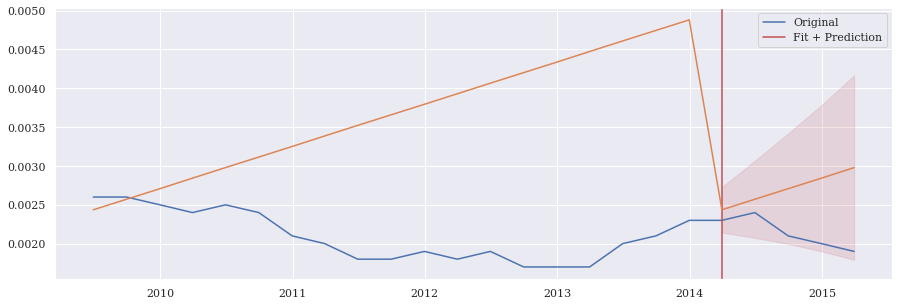

TRIMESTRE
2009-06-30    0.002436
2009-09-30    0.002572
2009-12-31    0.002708
2010-03-31    0.002843
2010-06-30    0.002979
2010-09-30    0.003115
2010-12-31    0.003251
2011-03-31    0.003387
2011-06-30    0.003523
2011-09-30    0.003659
2011-12-31    0.003795
2012-03-31    0.003930
2012-06-30    0.004066
2012-09-30    0.004202
2012-12-31    0.004338
2013-03-31    0.004474
2013-06-30    0.004610
2013-09-30    0.004746
2013-12-31    0.004882
dtype: float64 TRIMESTRE
2009-06-30    0.002436
2009-09-30    0.002572
2009-12-31    0.002708
2010-03-31    0.002843
2010-06-30    0.002979
2010-09-30    0.003115
2010-12-31    0.003251
2011-03-31    0.003387
2011-06-30    0.003523
2011-09-30    0.003659
2011-12-31    0.003795
2012-03-31    0.003930
2012-06-30    0.004066
2012-09-30    0.004202
2012-12-31    0.004338
2013-03-31    0.004474
2013-06-30    0.004610
2013-09-30    0.004746
2013-12-31    0.004882
2014-03-31    0.002436
2014-06-30    0.002572
2014-09-30    0.002708
2014-12-31    0.002843

In [ ]:
plot_arimax_fit(model,y_train,y_test,exog_train=X_train,exog_test=X_test)